Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Water Act Historic Compliance Violations

This notebook examines ECHO data using NPDES_QNCR_HISTORY, 
which reports the number of non-compliance violations in
four categories:
1) Effluent (E90) violations
2) Compliance schedule violagions,
3) Single event violations
4) Permit schedule violations

A state and congressional district must be chosen.

In [2]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display



Run this next cell, select a state, and then run the following cell.

In [3]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [15]:
my_state = dropdown_state.value

sql = "select REGISTRY_ID, FAC_NAME, FAC_STATE, NPDES_IDS, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113 " + \
    " from ECHO_EXPORTER " + \
    " where NPDES_FLAG = 'Y' and FAC_STATE = '" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
# print(data_location)


select REGISTRY_ID, FAC_NAME, FAC_STATE, NPDES_IDS, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113  from ECHO_EXPORTER  where NPDES_FLAG = 'Y' and FAC_STATE = 'NY'


In [16]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
echo_data.set_index( 'REGISTRY_ID', inplace=True )


In [17]:

num_facilities = echo_data.shape[0]
print("There are %s NDIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 10202 NDIS facilities in NY tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.

In [18]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [19]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s NDIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 496 NDIS facilities in NY district 1 tracked in the ECHO database.


Next look up the compliance violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [9]:
# The NPDES_ID is of the form GAISO1239, with the first two characters being the state abbreviation.
# Use that in the query to reduce the number of records and speed up the execution.

sql = "select NPDES_ID, YEARQTR, NUME90Q, NUMCVDT, NUMSVCD, NUMPSCH" + \
    " from NPDES_QNCR_HISTORY where YEARQTR > 20050 and YEARQTR < 20200 and " \
    " NPDES_ID like '" + my_state + "%'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
# print(sql)

qncr_data = pd.read_csv(data_location,header = 0)
qncr_data.set_index( "NPDES_ID", inplace=True)
qncr_data

,YEARQTR,NUME90Q,NUMCVDT,NUMSVCD,NUMPSCH
NPDES_ID,,,,,
NY0000043,20051,0,0,0,0
NY0000043,20052,0,0,0,0
NY0000043,20053,0,0,0,0
NY0000043,20054,0,0,0,0
NY0000043,20061,0,0,0,0
...,...,...,...,...,...
NYU900065,20062,0,0,0,0
NYU900065,20063,0,0,0,0
NYU900145,20061,0,0,0,0


In [10]:
# The NPDIS_IDS in ECHO_EXPORTER can contain multiple ids for a facility. 
# The string must be parsed to get each individual NPDES_ID to look up 
# in NPDES_QNCR_HISTORY.

my_cd_npdes = pd.DataFrame()
no_data_ids = []
for fac in my_cd_facs.itertuples():
    ids = fac.NPDES_IDS
    for npdes_id in ids.split():
        try:
            npdes_data = qncr_data.loc[ npdes_id ].copy()
            # Add the facility's index number to air_data, to refer to it.
            n = npdes_data.shape[0]
            fac_list = [fac.Index] * n
            npdes_data['facility'] = fac_list
            frames = [my_cd_npdes, npdes_data]
            my_cd_npdes = pd.concat( frames )
        except KeyError:
            no_data_ids.append( npdes_id )


In [11]:
my_cd_groups = my_cd_npdes.groupby( 'YEARQTR' )[['NUMCVDT','NUME90Q','NUMPSCH','NUMSVCD']].sum()

NUMCVDT - (Number of Compliance Schedule Violations in Quarter) A count of the number of compliance schedule violations reported in the quarter, defined by YEARQTR.

NUME90Q - (Number of E90 Violations in Quarter) A count of the number of effluent violations (E90) reported in the quarter, defined by YEARQTR.

NUMPSCH - (Number of Permit Schedule Violations in Quarter) A count of the number of permit schedule violations reported in the quarter, defined by YEARQTR.

NUMSVCD - (Number of Single Event Violations in Quarter) A count of the number of single event violations reported in the quarter, defined by PRHQRTR.

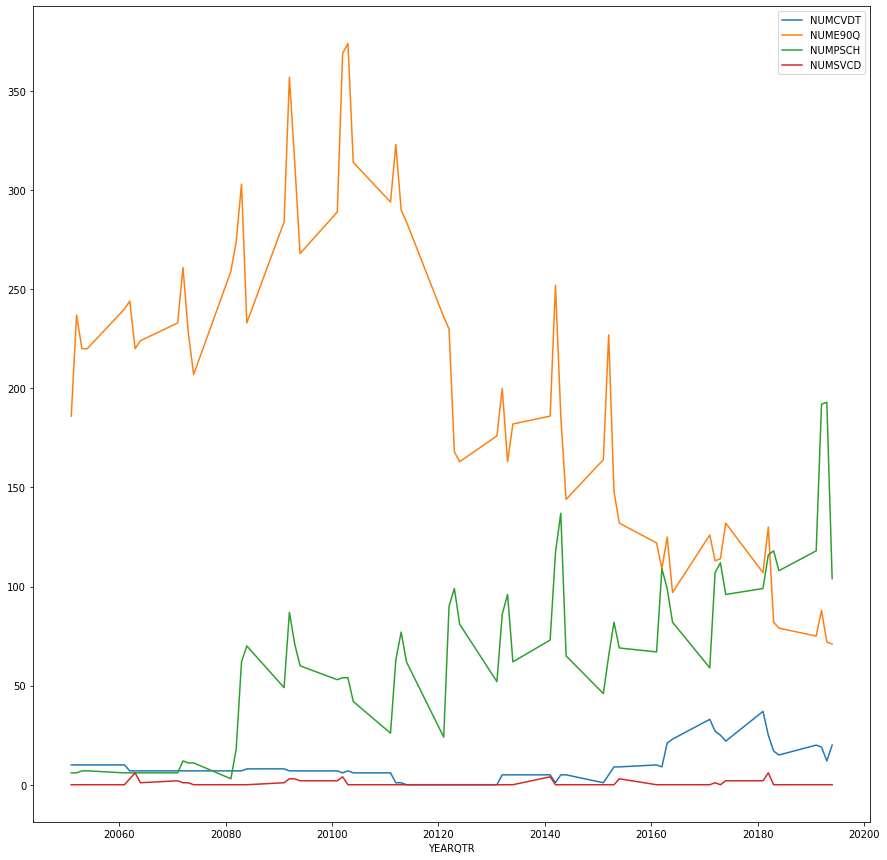

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
my_cd_groups.plot(ax=ax)

Q:  How is the number of effluent violations (NUME90Q) related to the number of permit schedule violations (NUMPSCH)?

Map the facilities in the Congressional District

In [20]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(my_cd_facs)
map_of_facilities_in_my_area

Add up all the compliance violations for each facility.

In [44]:
cd_npdes_group = my_cd_npdes.groupby( 'facility', as_index=False )[['NUMCVDT','NUME90Q','NUMPSCH','NUMSVCD']].sum()

Which facility has had the largest number of E90 violations, summed over the entire period since 2005?  
NUME90Q - (Number of E90 Violations in Quarter) A count of the number of effluent violations (E90) reported in the quarter, defined by YEARQTR.

In [63]:
fac_maxE90 = cd_npdes_group.loc[cd_npdes_group['NUME90Q'].idxmax()]
print(cd_npdes_group.loc[ cd_npdes_group['facility'] == fac_maxE90['facility']])
fac_maxE90_df = my_cd_facs.loc[ my_cd_facs.index == fac_maxE90['facility']]

        facility  NUMCVDT  NUME90Q  NUMPSCH  NUMSVCD
48  1.100067e+11      0.0   1076.0      0.0      0.0


In [64]:
map_of_maxE90 = mapper(fac_maxE90_df)
map_of_maxE90

What does this facility's history look like?

In [71]:
my_cd_npdes.loc[ my_cd_npdes['facility'] == fac_maxE90['facility']]

,0,NUMCVDT,NUME90Q,NUMPSCH,NUMSVCD,YEARQTR,facility
NY0237175,NaN,0.0,21.0,0.0,0.0,20051.0,1.100067e+11
NY0237175,NaN,0.0,32.0,0.0,0.0,20052.0,1.100067e+11
NY0237175,NaN,0.0,16.0,0.0,0.0,20053.0,1.100067e+11
NY0237175,NaN,0.0,15.0,0.0,0.0,20054.0,1.100067e+11
NY0237175,NaN,0.0,19.0,0.0,0.0,20061.0,1.100067e+11
NY0237175,NaN,0.0,0.0,0.0,0.0,20062.0,1.100067e+11
NY0237175,NaN,0.0,0.0,0.0,0.0,20063.0,1.100067e+11
NY0237175,NaN,0.0,0.0,0.0,0.0,20064.0,1.100067e+11
NY0237175,NaN,0.0,0.0,0.0,0.0,20071.0,1.100067e+11
NY0237175,NaN,0.0,0.0,0.0,0.0,20072.0,1.100067e+11
